<a href="https://colab.research.google.com/github/sangmin213/DialectClassification/blob/main/model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
import re
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
import pickle
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from torch.utils.data import Subset

In [ ]:
index2region={0:'gangwon', 1:'gyeongsang', 2:'jeonla', 3:'chungcheong', 4:'jeju'}
region2index = {v:k for k,v in index2region.items()}
region_shortening = ['GW','GS','JL','CC','JJ']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 데이터 셋 구성 (full dataset)
dataset_dir = '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/'

In [ ]:
region_dir = glob(dataset_dir)
region_dir

['/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/']

In [ ]:
for k, v in index2region.items():
    exec(f"{v}_dirs = glob(dataset_dir+'*_{v}/*')")
jeonla_dirs

['/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000004',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000006',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000008',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000012',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000007',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000001',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000003',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000009',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000002',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000005',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000018',
 '/content/drive/MyDrive/인공지능_프로젝트_Team_12/데이터/preprocessed_jeonla/DJDD20000017',
 '/content/drive

In [ ]:
def make_tuple_data(dirs, max_num):
    for i, region_dir in enumerate(dirs):
        if i>=max_num:break
        spectro_path = glob(region_dir+'/*_spectro.pickle')[0]
        mfcc_path = glob(region_dir+'/*_mfcc.pickle')[0]
        chroma_path = glob(region_dir+'/*_chroma.pickle')[0]
        
        with open(spectro_path, "rb") as f:
            spectro = pickle.load(f)
        with open(mfcc_path, "rb") as f:
            mfcc = pickle.load(f)
        with open(chroma_path, "rb") as f:
            chroma = pickle.load(f)

        if i == 0:
            spectro_data = spectro
            mfcc_data = mfcc
            chroma_data = chroma
        else:
            spectro_data = np.concatenate([spectro_data,spectro], axis=0)
            mfcc_data = np.concatenate([mfcc_data,mfcc], axis=0)
            chroma_data = np.concatenate([chroma_data,chroma], axis=0)
    if max_num ==0:return []
        
    r_data = [(s,m,c) for s,m,c in zip(spectro_data,mfcc_data,chroma_data)]
        
    return r_data

def make_tuple(max_num=2):
    jeonla_data = make_tuple_data(jeonla_dirs, 25)
    chungcheong_data = make_tuple_data(chungcheong_dirs, 20)
    gyeongsang_data = make_tuple_data(gyeongsang_dirs, 25)
    jeju_data = make_tuple_data(jeju_dirs, 32)
    gangwon_data = make_tuple_data(gangwon_dirs, 20)
    return jeonla_data, chungcheong_data, gyeongsang_data, jeju_data, gangwon_data

def print_data(r_data, region):
    if len(r_data)==0: return
    print(f"{region} data num: ", len(r_data))
    print(f"{region} tuple size", len(r_data[0]))
    print(f"{region} spec shape", r_data[0][0].shape)

jeonla_data, chungcheong_data, gyeongsang_data, jeju_data, gangwon_data = make_tuple()
print_data(jeonla_data, 'jeonla')
print_data(chungcheong_data, 'chungcheong')
print_data(gyeongsang_data, 'gyeongsang')
print_data(jeju_data, 'jeju')
print_data(gangwon_data, 'gangwon')

jeonla data num:  2717
jeonla tuple size 3
jeonla spec shape (201, 501)
chungcheong data num:  2946
chungcheong tuple size 3
chungcheong spec shape (201, 501)
gyeongsang data num:  2476
gyeongsang tuple size 3
gyeongsang spec shape (201, 501)
jeju data num:  2344
jeju tuple size 3
jeju spec shape (201, 501)
gangwon data num:  2310
gangwon tuple size 3
gangwon spec shape (201, 501)


In [ ]:
jeonla_data_l = []
for data in jeonla_data:
    y = [0,0,0,0,0]
    y[region2index['jeonla']] = 1
    jeonla_data_l.append((data,y))

chungcheong_data_l = []
for data in chungcheong_data:
    y = [0,0,0,0,0]
    y[region2index['chungcheong']] = 1
    chungcheong_data_l.append((data,y))

gyeongsang_data_l = []
for data in gyeongsang_data:
    y = [0,0,0,0,0]
    y[region2index['gyeongsang']] = 1
    gyeongsang_data_l.append((data,y))

jeju_data_l = []
for data in jeju_data:
    y = [0,0,0,0,0]
    y[region2index['jeju']] = 1
    jeju_data_l.append((data,y))

gangwon_data_l = []
for data in gangwon_data:
    y = [0,0,0,0,0]
    y[region2index['gangwon']] = 1
    gangwon_data_l.append((data,y))

In [ ]:
datasumup = np.concatenate([jeonla_data_l, chungcheong_data_l, gangwon_data_l, jeju_data_l, gyeongsang_data_l], axis=0)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
from sklearn.preprocessing import normalize
class MultiModalDataset(Dataset):

    def __init__(self, data):

        self.data = data

    def __getitem__(self, idx):
        datas, label = self.data[idx]
        spec, mfcc, chroma = datas
        spec, mfcc, chroma = normalize(spec), normalize(mfcc), normalize(chroma)
        spec, mfcc, chroma = torch.tensor(spec, dtype=torch.float32), torch.tensor(mfcc, dtype=torch.float32), torch.tensor(chroma, dtype=torch.float32)
        spec, mfcc, chroma = spec.unsqueeze(0), mfcc.unsqueeze(0), chroma.unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)

        data = (spec, mfcc, chroma)
        return data, label
    
    def __len__(self):
        return len(self.data)

In [ ]:
dataset = MultiModalDataset(datasumup)
len(dataset)

12793

# ResNet

In [ ]:
class BasicBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.seq1 = nn.Sequential(self.conv1, self.bn1, self.relu)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.seq2 = nn.Sequential(self.conv2, self.bn2)
        
        self.down_flag = False
        if in_channels != out_channels: self.down_flag = True

        self.downsample = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1), stride=2, padding=0, bias=False)
    
    def forward(self, x):
        #print(x.shape)
        y = self.seq1(x)
        #print(y.shape)
        y = self.seq2(y)
        #print(y.shape)

        if self.down_flag:
            x = self.downsample(x)
        
        y = self.relu(y)
        #print(x.shape)
        #print(y.shape)
        y = y + x

        return y
        

In [ ]:
class ResNet18(nn.Module):

    def __init__(self, in_channels, output_dim=256, model_type='spec',best_model_save_path="./ResNet_best_model.pt"):
        super(ResNet18, self).__init__()

        self.best_model_save_path = best_model_save_path
        self.data_type = model_type

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=2, padding=3)
        self.BN1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=1)

        self.seq1 = nn.Sequential(self.conv1, self.BN1, self.pool1)

        self.seq2 = nn.Sequential(BasicBlock(64,64), BasicBlock(64,64))
        self.seq3 = nn.Sequential(BasicBlock(64,64), BasicBlock(64, 128, stride=2))
        self.seq4 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,128))
        self.seq5 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,256,stride=2))

        self.avg_pool1 = nn.AdaptiveAvgPool2d((1,1))
        # if model_type=='spec':
        #     self.fc1 = nn.Linear(256*13*32, output_dim)
        # elif model_type=='mfcc':
        #     self.fc1 = nn.Linear(256*7*32, output_dim)
        # elif model_type=='chroma':
        #     self.fc1 = nn.Linear(256*1*32, output_dim)
        self.fc1 = nn.Linear(256, output_dim)


        self.lastlayer = nn.Sequential(self.fc1, self.relu)

    def forward(self, x):
        y = self.seq1(x)
        y = self.seq2(y)
        y = self.seq3(y)
        y = self.seq4(y)
        y = self.seq5(y)
        y = self.avg_pool1(y)
        y = y.view(y.shape[0],-1)
        y = self.lastlayer(y)

        return y

    def train_(self, train_loader, val_loader, learning_rate, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        self.pred_labels_train = []
        self.real_labels_train = []
        self.pred_labels_val = None
        self.real_labels_val = None

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_f=nn.CrossEntropyLoss()

        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data

                if self.data_type=="mfcc":
                    batch_data=mfcc.to(device)
                elif self.data_type=="spec":
                    batch_data=spec.to(device)
                elif self.data_type=="chroma":
                    batch_data=chroma.to(device)
                
                batch_label = batch_label.to(device)

                self.optimizer.zero_grad()

                pred = self.forward(batch_data) # (batch_size, 5)
                loss = self.loss_f(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data.shape[0]
                batch_label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(batch_label).sum().item()
                
                if epoch==epochs: #last epoch
                    self.pred_labels_train.append(pred_indices)
                    self.real_labels_train.append(batch_label)
                #for p, l in zip(pred_indices, batch_label):
                #    print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")
            

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            if epoch==epochs: #last epoch
                self.pred_labels_val=predicted.cpu().numpy()
                self.real_labels_val=labels.cpu().numpy()
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")
            print(f"epoch {epoch} val loss: {val_loss}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
        
        self.pred_labels_train = torch.cat(self.pred_labels_train, dim=0)
        self.real_labels_train = torch.cat(self.real_labels_train, dim=0)
        self.pred_labels_train = self.pred_labels_train.cpu().numpy()
        self.real_labels_train = self.real_labels_train.cpu().numpy()
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                if self.data_type=="mfcc":
                    batch_data=mfcc.to(device)
                elif self.data_type=="spec":
                    batch_data=spec.to(device)
                elif self.data_type=="chroma":
                    batch_data=chroma.to(device)
                batch_label = batch_label.to(device)
                
                pred = self.forward(batch_data)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss_f(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss
    
    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss
        elif which=='confusion_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening)
            plt.title('train confusion matrix')
            plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/{self.data_type}_ResNet/ResNet_{which}_{self.data_type}.png")
            plt.show()
            return
        elif which=='confusion_normalize_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening, normalize='true')
            plt.title('train confusion matrix')
            plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/{self.data_type}_ResNet/ResNet_{which}_{self.data_type}.png")
            plt.show()    
            return        
        elif which=='confusion_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening)
            plt.title('val confusion matrix')
            plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/{self.data_type}_ResNet/ResNet_{which}_{self.data_type}.png")
            plt.show()
            return
        elif which=='confusion_normalize_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening, normalize='true')
            plt.title('val confusion matrix')
            plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/spec_ResNet/ResNet_{which}_{self.data_type}.png")
            plt.show()    
            return   
            

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/{self.data_type}_ResNet/ResNet_{which}_{self.data_type}.png")
        plt.show()

# LeNet

In [ ]:
class Block(nn.Module):
    def __init__(self,input_channel, output_channel, kernel_size, stride=1, padding=0):
        super(Block,self).__init__()

        self.conv1=nn.Conv2d(input_channel,output_channel,kernel_size=kernel_size,padding=padding) # no stride
        self.conv2=nn.Conv2d(output_channel,output_channel,kernel_size=kernel_size,stride=stride,padding=padding) # stride if down sampling
        self.bn=nn.BatchNorm2d(output_channel)
        self.relu=nn.ReLU()

        self.layer=nn.Sequential(self.conv1, self.bn, self.relu, self.conv2, self.bn)

        self.stride=stride
        self.iden = nn.Conv2d(input_channel, output_channel, kernel_size=(1,1), stride=1)
        if input_channel==64:
            self.iden = nn.Conv2d(input_channel, output_channel, kernel_size=(1,1), stride=1)

    def forward(self,x):
        y = self.layer(x)
        if self.stride==1: # stride==2 인 경우는 downsampling 구간이기 때문에 residual 안함
            y = y + self.iden(x)
        y = self.relu(y)

        return y

In [ ]:
class LeNet(nn.Module):
    def __init__(self,data_type="mfcc",method="origin",best_model_save_path="./LeNet_best_model.pt"):
        super(LeNet,self).__init__()
        
        self.best_model_save_path = best_model_save_path
        self.data_type=data_type
        self.method=method

        if data_type=="mfcc": # (1,100,501)
            self.conv1=nn.Conv2d(1,64,kernel_size=(6,7),stride=2,padding=3)
        elif data_type=="spec": #(1,201,501)
            self.conv1=nn.Conv2d(1,64,kernel_size=(7,7),stride=2,padding=3)
        elif data_type=="chroma": #(1,12,501)
            self.conv1=nn.Conv2d(1,64,kernel_size=(6,7),stride=1,padding=3)
        self.maxpool=nn.MaxPool2d(kernel_size=(3,3),stride=2,padding=1)
        self.avgpool=nn.AdaptiveAvgPool2d((1,1)) # global avg pool
        self.relu=nn.ReLU()

        self.seq1=nn.Sequential(self.conv1,self.relu,self.maxpool)  # (1,100,501)/(1,12,501)/(1,201,501) -> (64,51,251)/(1,13,251)/(1,101,251).conv -> (64,25,126)/(64,7,126)/(64,51,126).maxpool
        self.seq2=nn.Sequential(Block(64,64,(3,3),padding=1),Block(64,64,(3,3),padding=1),Block(64,128,(3,4),stride=2,padding=1)) # (64,25,126) -> (64,25,126).block -> (64,25,126).block -> (128,13,63)/(128,4,63)/(128,26,63).block 
        if data_type=="mfcc":
            self.seq3=nn.Sequential(Block(128,128,(3,3),padding=1),Block(128,128,(3,3),padding=1),Block(128,256,(3,3),stride=2,padding=1)) # (128,13,63) -> (128,13,63).block -> (128,13,63).block -> (256,7,32).block 
        elif data_type=="spec":
            self.seq3=nn.Sequential(Block(128,128,(3,3),padding=1),Block(128,128,(3,3),padding=1),Block(128,256,(4,3),stride=2,padding=1)) # (128,26,63) -> ... -> (256,12,32).block 
        elif data_type=="chroma":
            self.seq3=nn.Sequential(Block(128,128,(3,3),padding=1),Block(128,128,(3,3),padding=1),Block(128,256,(2,3),stride=2,padding=1)) # (128,4,63)/(128,26,63) -> ... -> (256,2,32)/(256,13,32).block 
        self.seq4=nn.Sequential(Block(256,256,(3,3),padding=1),Block(256,256,(3,3),padding=1),self.avgpool) # ... -> (256,1,1).avgpool

        if self.method=="multimodal":
            self.fc=nn.Linear(256,256)
        if self.method=="origin":
            self.fc=nn.Linear(256,5)
            self.loss=nn.CrossEntropyLoss()
            self.optimizer=optim.Adam(self.parameters(),lr=0.0001)

        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []

    def forward(self,x):       
        y=self.seq1(x)
        y=self.seq2(y)
        y=self.seq3(y)
        y=self.seq4(y)
        y=y.view(y.shape[0],-1)
        y=self.fc(y)
        return y

    def train_(self, train_loader, val_loader, learning_rate, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        self.pred_labels_train = []
        self.real_labels_train = []
        self.pred_labels_val = None
        self.real_labels_val = None

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_f=nn.CrossEntropyLoss()

        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data

                if self.data_type=="mfcc":
                    batch_data=mfcc.to(device)
                elif self.data_type=="spec":
                    batch_data=spec.to(device)
                elif self.data_type=="chroma":
                    batch_data=chroma.to(device)
                
                batch_label = batch_label.to(device)

                self.optimizer.zero_grad()

                pred = self.forward(batch_data) # (batch_size, 5)
                loss = self.loss_f(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data.shape[0]
                batch_label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(batch_label).sum().item()
                
                if epoch==epochs: #last epoch
                    self.pred_labels_train.append(pred_indices)
                    self.real_labels_train.append(batch_label)
                #for p, l in zip(pred_indices, batch_label):
                #    print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")
            

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            if epoch==epochs: #last epoch
                self.pred_labels_val=predicted.cpu().numpy()
                self.real_labels_val=labels.cpu().numpy()
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")
            print(f"epoch {epoch} val loss: {val_loss}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
        
        self.pred_labels_train = torch.cat(self.pred_labels_train, dim=0)
        self.real_labels_train = torch.cat(self.real_labels_train, dim=0)
        self.pred_labels_train = self.pred_labels_train.cpu().numpy()
        self.real_labels_train = self.real_labels_train.cpu().numpy()
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                if self.data_type=="mfcc":
                    batch_data=mfcc.to(device)
                elif self.data_type=="spec":
                    batch_data=spec.to(device)
                elif self.data_type=="chroma":
                    batch_data=chroma.to(device)
                batch_label = batch_label.to(device)
                
                pred = self.forward(batch_data)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss_f(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss
    
    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss
        elif which=='confusion_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening)
            plt.title('train confusion matrix')
            plt.savefig(f"./result/LeNet_{which}_{self.data_type}.png")
            plt.show()
            return
        elif which=='confusion_normalize_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening, normalize='true')
            plt.title('train confusion matrix')
            plt.savefig(f"./result/LeNet_{which}_{self.data_type}.png")
            plt.show()    
            return        
        elif which=='confusion_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening)
            plt.title('val confusion matrix')
            plt.savefig(f"./result/LeNet_{which}_{self.data_type}.png")
            plt.show()
            return
        elif which=='confusion_normalize_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening, normalize='true')
            plt.title('val confusion matrix')
            plt.savefig(f"./result/LeNet_{which}_{self.data_type}.png")
            plt.show()    
            return   
            

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"./result/LeNet_{which}_{self.data_type}.png")
        plt.show()

# LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self,data_type="mfcc",method="origin",best_model_save_path="./LSTM_best_model.pt"):
        super(LSTM,self).__init__()

        self.best_model_save_path=best_model_save_path
        self.data_type=data_type
        self.method=method

        self.hidden_size=64
        self.num_layers=1
        if self.data_type=="mfcc":
            self.input_size=100  #mfcc 기준
        elif self.data_type=="spec":
            self.input_size=201  #mfcc 기준
        elif self.data_type=="chroma":
            self.input_size=12  #mfcc 기준

        self.lstm=nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size, num_layers =self.num_layers,batch_first=True)
        
        if self.method=="multimodal":
            self.linear=nn.Linear(32064,256) # 밑에 forward에서 y.reshape 부분 보면 이해됨.  hidden -> 256 output vector for multimodal 
        elif self.method=="origin":
            self.linear=nn.Linear(32064,5) # hidden -> 지역 개수

    def forward(self,x):
        x = x.reshape(x.shape[0],-1,x.shape[3]) # 32,100,501 = (batch size, 100, 501)
        x = x.view(x.shape[0],x.shape[2],-1) # 32,501,100 = (batch size, sequence len, input size)
        
        #Initial hidden state
        h_0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)).to(device=device)
        #Initial cell state
        c_0 = torch.zeros((self.num_layers, x.shape[0], self.hidden_size)).to(device=device)
        
        y, (h_n,c_n) =self.lstm(x,(h_0,c_0))
        y = y.reshape(y.shape[0],-1) # y = (batch size, sequence len * hidden_size) = (32, 501*64) 
        y = self.linear(y)

        return y

    def train_(self, train_loader, val_loader, learning_rate, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        self.pred_labels_train = []
        self.real_labels_train = []
        self.pred_labels_val = None
        self.real_labels_val = None

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.loss_f=nn.CrossEntropyLoss()

        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data

                if self.data_type=="mfcc":
                    batch_data=mfcc.to(device)
                elif self.data_type=="spec":
                    batch_data=spec.to(device)
                elif self.data_type=="chroma":
                    batch_data=chroma.to(device)
                
                batch_label = batch_label.to(device)

                self.optimizer.zero_grad()

                pred = self.forward(batch_data) # (batch_size, 5)
                loss = self.loss_f(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data.shape[0]
                batch_label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(batch_label).sum().item()
                
                if epoch==epochs: #last epoch
                    self.pred_labels_train.append(pred_indices)
                    self.real_labels_train.append(batch_label)
                #for p, l in zip(pred_indices, batch_label):
                #    print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")
            

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            if epoch==epochs: #last epoch
                self.pred_labels_val=predicted.cpu().numpy()
                self.real_labels_val=labels.cpu().numpy()
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")
            print(f"epoch {epoch} val loss: {val_loss}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
        
        self.pred_labels_train = torch.cat(self.pred_labels_train, dim=0)
        self.real_labels_train = torch.cat(self.real_labels_train, dim=0)
        self.pred_labels_train = self.pred_labels_train.cpu().numpy()
        self.real_labels_train = self.real_labels_train.cpu().numpy()
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                if self.data_type=="mfcc":
                    batch_data=mfcc.to(device)
                elif self.data_type=="spec":
                    batch_data=spec.to(device)
                elif self.data_type=="chroma":
                    batch_data=chroma.to(device)
                batch_label = batch_label.to(device)
                
                pred = self.forward(batch_data)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss_f(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss
    
    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss
        elif which=='confusion_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening)
            plt.title('train confusion matrix')
            plt.savefig(f"./result/LSTM_{which}_{self.data_type}.png")
            plt.show()
            return
        elif which=='confusion_normalize_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening, normalize='true')
            plt.title('train confusion matrix')
            plt.savefig(f"./result/LSTM_{which}_{self.data_type}.png")
            plt.show()    
            return        
        elif which=='confusion_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening)
            plt.title('val confusion matrix')
            plt.savefig(f"./result/LSTM_{which}_{self.data_type}.png")
            plt.show()
            return
        elif which=='confusion_normalize_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening, normalize='true')
            plt.title('val confusion matrix')
            plt.savefig(f"./result/LSTM_{which}_{self.data_type}.png")
            plt.show()    
            return   
            

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"./result/LSTM_{which}_{self.data_type}.png")
        plt.show()



# Multimodal

In [ ]:
class MultiModalDialectClassifier(nn.Module):
    
    def __init__(self, hidden_dim=1024, out_dim=5, spec="ResNet", mfcc = "ResNet", chroma="ResNet", best_model_save_path="./best_model.pt"):
        super(MultiModalDialectClassifier, self).__init__()

        self.mfcc=mfcc
        self.spec=spec
        self.chroma=chroma

        self.best_model_save_path = best_model_save_path
        
        # spec part
        if self.spec=="ResNet":
            self.spec_NN = ResNet18(1,256, model_type='spec')
        elif self.spec=="LeNet":
            self.spec_NN = LeNet("spec","multimodal")
        elif self.spec=="LSTM":
            self.spec_NN = LSTM("spec","multimodal")

        # mfcc part
        if self.mfcc=="ResNet":
            self.mfcc_NN = ResNet18(1,256, model_type='mfcc')
        elif self.mfcc=="LeNet":
            self.mfcc_NN = LeNet("mfcc","multimodal")
        elif self.mfcc=="LSTM":
            self.mfcc_NN = LSTM("mfcc","multimodal")

        # chroma part
        if self.chroma=="ResNet":
            self.chroma_NN = ResNet18(1,256, model_type='chroma')
        elif self.chroma=="LeNet":
            self.chroma_NN = LeNet("chroma","multimodal")
        elif self.chroma=="LSTM":
            self.chroma_NN = LSTM("chroma","multimodal")

        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(256*3, 256)
        self.fc2 = nn.Linear(256,out_dim)
        self.lastlayer_resnet = nn.Sequential(self.fc1, self.relu, self.fc2)

        self.loss_f = nn.CrossEntropyLoss()
        self.optimizer = None
    
    def forward(self, x):
        spec_x, mfcc_x, chroma_x = x

        spec_y = self.spec_NN(spec_x)
        mfcc_y = self.mfcc_NN(mfcc_x)
        chroma_y = self.chroma_NN(chroma_x)
        y = torch.cat([spec_y, mfcc_y, chroma_y], dim=1)
        y = y.view(y.shape[0], -1)
    
        y = self.lastlayer_resnet(y)

        return y
    
    def train_(self, train_loader, val_loader, learning_rate, epochs, threshold, device): # threshold: for early stop
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        self.pred_labels_train = []
        self.real_labels_train = []
        self.pred_labels_val = None
        self.real_labels_val = None

        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)


        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)

                self.optimizer.zero_grad()

                pred = self.forward(batch_data) # (batch_size, 5)
                loss = self.loss_f(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data[0].shape[0]
                batch_label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(batch_label).sum().item()
                
                # make pred_labels_train for every epoch for early stopping not only for last epoch
                self.pred_labels_train.append(pred_indices)
                self.real_labels_train.append(batch_label)
                #for p, l in zip(pred_indices, batch_label):
                #    print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")
            

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")
            print(f"epoch {epoch} val loss: {val_loss}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)

            if epoch==epochs or val_acc>=threshold: #last epoch or early stopped
                self.pred_labels_val=predicted.cpu().numpy()
                self.real_labels_val=labels.cpu().numpy()
            
            if val_acc>=threshold:
                print("Early stopped!")
                break
        
        self.pred_labels_train = torch.cat(self.pred_labels_train, dim=0)
        self.real_labels_train = torch.cat(self.real_labels_train, dim=0)
        self.pred_labels_train = self.pred_labels_train.cpu().numpy()
        self.real_labels_train = self.real_labels_train.cpu().numpy()
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                pred = self.forward(batch_data)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss_f(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss
    
    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss
        elif which=='confusion_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening)
            plt.title('train confusion matrix')
            plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/Multimodal/Multimodal_model_{which}.png")
            plt.show()
            return
        elif which=='confusion_normalize_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening, normalize='true')
            plt.title('train confusion matrix')
            plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/Multimodal/Multimodal_model_{which}.png")
            plt.show()    
            return        
        elif which=='confusion_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening)
            plt.title('val confusion matrix')
            plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/Multimodal/Multimodal_model_{which}.png")
            plt.show()
            return
        elif which=='confusion_normalize_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening, normalize='true')
            plt.title('val confusion matrix')
            plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/Multimodal/Multimodal_model_{which}.png")
            plt.show()    
            return   
            

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/Multimodal/Multimodal_model_{which}.png")
        plt.show()

    def getConvLayers(self, lenet):
        weights = []
        conv_layers = []
        for i in range(len(lenet)):
            if type(lenet[i]) == nn.Conv2d:
                weights.append(lenet[i].weight)
                conv_layers.append(lenet[i])
            elif type(lenet[i]) == nn.Sequential:
                for basic in lenet[i].children(): # basic block
                    for in_basic in basic.children():
                        if type(in_basic) == nn.Conv2d:
                            weights.append(in_basic.weight)
                            conv_layers.append(in_basic)
                        if type(in_basic) == nn.Sequential:
                            for in_basic_in_sequential in in_basic:
                                if type(in_basic_in_sequential) == nn.Conv2d:
                                    weights.append(in_basic_in_sequential.weight)
                                    conv_layers.append(in_basic_in_sequential)            
        return weights, conv_layers

    def extractConvLayer(self):
        children_ = list(self.children())
        spec_lenet = list(children_[0].children())
        mfcc_lenet = list(children_[1].children())
        chroma_lenet = list(children_[2].children()) 

        spec_weights, spec_layers = self.getConvLayers(spec_lenet)
        mfcc_weights, mfcc_layers = self.getConvLayers(mfcc_lenet)
        chroma_weights, chroma_layers = self.getConvLayers(chroma_lenet)

        self.spec_weights = spec_weights
        self.spec_layers = spec_layers
        self.mfcc_weights = mfcc_weights
        self.mfcc_layers = mfcc_layers
        self.chroma_weights = chroma_weights
        self.chroma_layers = chroma_layers
        
        return spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers

    def plotFilter(self, where='first', data_type='spec', when='before_train'):
        if data_type == 'spec':
            filters = self.spec_weights
        elif data_type == 'mfcc':
            filters = self.mfcc_weights
        elif data_type == 'chroma':
            filters = self.chroma_weights
        x_len = 0
        y_len = 0
        if where=='first': # 64x1x7x7
            filters = filters[0]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(20,17))
            x_len=8
            y_len=8
        elif where=='middle': # 128x64x3x3
            filters = filters[16]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(30,25))
            x_len= 16
            y_len= 8
        elif where=='last': # 256x256x3x3
            filters = filters[len(filters)-2]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(40,32))
            x_len=16
            y_len=16
        for i,filter in enumerate(filters):
            plt.subplot(x_len, y_len, i+1)
            plt.imshow(filter.detach().cpu(), cmap='gray')
            plt.axis('off')
        plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/Multimodal/Multimodal_{data_type}_filter_{where}_{when}.png")
        plt.show()
        plt.close()
    
    def plotOriginalImage(self, data):
        plt.imshow(data[0,:,:])
        plt.show()

    def plotFeatureMap(self, data, where='first', data_type='spec', when='before_train'):
        if data_type == 'spec':
            layers = self.spec_layers
            x_len = 8
            y_len = 8
        elif data_type == 'mfcc':
            layers = self.mfcc_layers
            x_len = 16
            y_len = 4
        elif data_type == 'chroma':
            layers = self.chroma_layers
            x_len = 32
            y_len = 2

        if where=='first':
            plt.figure(figsize=(20,17))
            layer = layers[0]
        elif where=='middle':
            pass
        elif where=='last':
            pass
        results = layer(data.to(device)) # 64x?x251
        for i, result in enumerate(results):
            plt.subplot(x_len, y_len, i+1)
            plt.imshow(result.detach().cpu())
            plt.axis('off')
        plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/Multimodal/Multimodal_{data_type}_feature_map_{where}_{when}.png")
        plt.show()
        plt.close()      

        
        
        

# Cross Validation

In [ ]:
def CV_Plot(title, arg, y):
        X = [i for i in range(1, len(y) + 1)]
        plt.xlabel("epoch")
        plt.ylabel(title)
        plt.title(title)
        plt.plot(X, y, label=title)
        plt.savefig(f"/content/drive/MyDrive/인공지능_프로젝트_Team_12/result/spec_ResNet/ResNet_{title}_{arg}.png")
        plt.show()

In [ ]:
def CrossValidation(dataset, learning_rate, epochs, device, method = "ResNet",data_type="mfcc"):
        hparams = []
        for i in range(len(learning_rate)):
            for j in range(len(epochs)):
                hparams.append((learning_rate[i], epochs[j]))
        print(hparams)

        train_dataset_l = []
        validation_dataset_l = []

        kf = KFold(n_splits = 5, shuffle = True, random_state = 50)

        for train_index, test_index in kf.split(train_dataset):
            train_dataset_l.append(Subset(train_dataset,train_index))
            validation_dataset_l.append(Subset(train_dataset,test_index))

        result = []
        for i in range(len(hparams)):
            lr = hparams[i][0]
            e = hparams[i][1]

            print(f"Learning rate : {lr}, Epochs : {e}")

            last_val_acc = []
            for j in range(5):
                print(f"#{j+1} validation")
                if method=="Multimodal_ResNet":
                    model = MultiModalDialectClassifier(spec="ResNet",mfcc="ResNet",chroma="ResNet").to(device) # 매번 새로 정의해서 다시 학습해야함
                elif method=="Multimodal":
                    model = MultiModalDialectClassifier(spec="LSTM",mfcc="LSTM",chroma="ResNet").to(device) # 매번 새로 정의해서 다시 학습해야함
                elif method=="ResNet":
                    model = ResNet18(1,output_dim=5,model_type=data_type).to(device) # 매번 새로 정의해서 다시 학습해야함
                elif method=="LeNet":
                    model = LeNet(data_type=data_type).to(device) # 매번 새로 정의해서 다시 학습해야함
                elif method=="LSTM":
                    model = LSTM(data_type=data_type).to(device) # 매번 새로 정의해서 다시 학습해야함
                train_loader = DataLoader(train_dataset_l[j], batch_size=32, shuffle=True)
                validation_loader = DataLoader(validation_dataset_l[j], batch_size=32, shuffle=True)

                model.train_(train_loader, validation_loader, lr, e, device)
                last_val_acc.append(model.val_accuracy[-1])
                    
                # model.plot('train_acc')
                # model.plot('val_acc')
            result.append((np.array(last_val_acc)).mean())

        idx = result.index(max(result))
        best_lr, best_ep = hparams[idx]
        print(f"Best Learning Rate : {best_lr}, Best Epoch : {best_ep}")

        return best_lr, best_ep

In [ ]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

사용법

1. CrossValidation() 함수를 사용하여 테스트한다. 이 때 결정할 인자는 아래와 같다.
2. method를 다음 중 결정한다. {"ResNet","LeNet","LSTM","Multimodal_ResNet","Multimodal_LeNet"}

3. dat_type을 다음 중 결정한다. {"spec","mfcc","chroma"} -> multimodal은 모든 데이터를 사용하게끔 설계되어 있으므로 안 적어도 되고, 아무 데이터 타입을 적어도 상관없다.

In [ ]:
lr = [0.0001,0.0005, 0.001]
ep = [30]

best_lr, best_ep = CrossValidation(train_dataset, learning_rate= lr, epochs= ep, device = device, method = "ResNet",data_type="spec")

[(0.0001, 30), (0.0005, 30), (0.001, 30)]
Learning rate : 0.0001, Epochs : 30
#1 validation


100%|██████████| 256/256 [01:03<00:00,  4.03it/s]


epoch 1 time: 63.56078577041626sec(s).
epoch 1 train accuracy: 0.7608403566630023
epoch 1 loss: 0.6289709693519399


100%|██████████| 64/64 [00:06<00:00,  9.80it/s]


epoch 1 val accuracy: 0.9096238397655105
epoch 1 val loss: 0.25322534784208983


100%|██████████| 256/256 [01:03<00:00,  4.06it/s]


epoch 2 time: 63.13824510574341sec(s).
epoch 2 train accuracy: 0.9334310492243801
epoch 2 loss: 0.19360144337406382


100%|██████████| 64/64 [00:05<00:00, 10.74it/s]


epoch 2 val accuracy: 0.8895945285784074
epoch 2 val loss: 0.26833722658921033


100%|██████████| 256/256 [01:04<00:00,  3.98it/s]


epoch 3 time: 64.25798988342285sec(s).
epoch 3 train accuracy: 0.9628679614022231
epoch 3 loss: 0.11605052851518849


100%|██████████| 64/64 [00:06<00:00, 10.55it/s]


epoch 3 val accuracy: 0.9550561797752809
epoch 3 val loss: 0.13709439945523627


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 4 time: 64.96354484558105sec(s).
epoch 4 train accuracy: 0.9703187980945401
epoch 4 loss: 0.09136841217696201


100%|██████████| 64/64 [00:05<00:00, 10.76it/s]


epoch 4 val accuracy: 0.9374694675134343
epoch 4 val loss: 0.20446147953043692


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 5 time: 64.92405962944031sec(s).
epoch 5 train accuracy: 0.9754488823744961
epoch 5 loss: 0.07361098625187878


100%|██████████| 64/64 [00:05<00:00, 10.71it/s]


epoch 5 val accuracy: 0.9560332193453834
epoch 5 val loss: 0.1200500467675738


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 6 time: 64.83032560348511sec(s).
epoch 6 train accuracy: 0.9838768779772811
epoch 6 loss: 0.053236990500408865


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]


epoch 6 val accuracy: 0.9599413776257938
epoch 6 val loss: 0.10856210233760066


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 7 time: 64.92413425445557sec(s).
epoch 7 train accuracy: 0.9868083547086846
epoch 7 loss: 0.04211921833757515


100%|██████████| 64/64 [00:05<00:00, 10.74it/s]


epoch 7 val accuracy: 0.9760625305324866
epoch 7 val loss: 0.07214274939906318


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 8 time: 64.83590817451477sec(s).
epoch 8 train accuracy: 0.9880298033467693
epoch 8 loss: 0.034515508215008595


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]


epoch 8 val accuracy: 0.9301416707376648
epoch 8 val loss: 0.19971535727381706


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 9 time: 64.81005358695984sec(s).
epoch 9 train accuracy: 0.9886405276658117
epoch 9 loss: 0.03819824641914238


100%|██████████| 64/64 [00:05<00:00, 10.72it/s]


epoch 9 val accuracy: 0.9789936492427943
epoch 9 val loss: 0.05964904539723648


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 10 time: 64.91390252113342sec(s).
epoch 10 train accuracy: 0.9968242335409796
epoch 10 loss: 0.014494428691136818


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 10 val accuracy: 0.9057156814851002
epoch 10 val loss: 0.4045145452255383


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 11 time: 64.78521251678467sec(s).
epoch 11 train accuracy: 0.9932820324905338
epoch 11 loss: 0.022820659682111


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 11 val accuracy: 0.978505129457743
epoch 11 val loss: 0.07378173588949721


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 12 time: 64.8987090587616sec(s).
epoch 12 train accuracy: 0.9938927568095761
epoch 12 loss: 0.021565294248603095


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 12 val accuracy: 0.9794821690278456
epoch 12 val loss: 0.059715449784562225


100%|██████████| 256/256 [01:04<00:00,  3.96it/s]


epoch 13 time: 64.7379047870636sec(s).
epoch 13 train accuracy: 0.9930377427629168
epoch 13 loss: 0.023062581957105976


100%|██████████| 64/64 [00:05<00:00, 10.70it/s]


epoch 13 val accuracy: 0.93209574987787
epoch 13 val loss: 0.17868692797492258


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 14 time: 64.79358839988708sec(s).
epoch 14 train accuracy: 0.9997557102723831
epoch 14 loss: 0.004796502896795118


100%|██████████| 64/64 [00:05<00:00, 10.70it/s]


epoch 14 val accuracy: 0.9858329262335125
epoch 14 val loss: 0.043710016972909216


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 15 time: 64.90206098556519sec(s).
epoch 15 train accuracy: 0.9924270184438745
epoch 15 loss: 0.019979807686070217


100%|██████████| 64/64 [00:05<00:00, 10.76it/s]


epoch 15 val accuracy: 0.5857352222765022
epoch 15 val loss: 5.356730993837118


100%|██████████| 256/256 [01:04<00:00,  3.96it/s]


epoch 16 time: 64.74218773841858sec(s).
epoch 16 train accuracy: 0.9892512519848541
epoch 16 loss: 0.03302091134639795


100%|██████████| 64/64 [00:05<00:00, 10.75it/s]


epoch 16 val accuracy: 0.9882755251587689
epoch 16 val loss: 0.04196909309575858


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 17 time: 64.86593580245972sec(s).
epoch 17 train accuracy: 0.9987785513619152
epoch 17 loss: 0.0060444221918771746


100%|██████████| 64/64 [00:06<00:00, 10.63it/s]


epoch 17 val accuracy: 0.9829018075232047
epoch 17 val loss: 0.061470617776649306


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 18 time: 64.81743574142456sec(s).
epoch 18 train accuracy: 0.9986564064981067
epoch 18 loss: 0.005458829328915726


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]


epoch 18 val accuracy: 0.9765510503175379
epoch 18 val loss: 0.08406216353841955


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 19 time: 64.87003827095032sec(s).
epoch 19 train accuracy: 0.9976792475876389
epoch 19 loss: 0.007772108052918725


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]


epoch 19 val accuracy: 0.9467513434294089
epoch 19 val loss: 0.2026287784683518


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 20 time: 64.84726524353027sec(s).
epoch 20 train accuracy: 0.9908391352143643
epoch 20 loss: 0.02419506833456353


100%|██████████| 64/64 [00:05<00:00, 10.76it/s]


epoch 20 val accuracy: 0.9794821690278456
epoch 20 val loss: 0.05944467504014028


100%|██████████| 256/256 [01:04<00:00,  3.96it/s]


epoch 21 time: 64.72753834724426sec(s).
epoch 21 train accuracy: 0.9935263222181507
epoch 21 loss: 0.01682036370766582


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 21 val accuracy: 0.9814362481680508
epoch 21 val loss: 0.053350731379396166


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 22 time: 64.79593658447266sec(s).
epoch 22 train accuracy: 0.9982899719066813
epoch 22 loss: 0.0059446284766693225


100%|██████████| 64/64 [00:05<00:00, 10.74it/s]


epoch 22 val accuracy: 0.9848558866634098
epoch 22 val loss: 0.05115139610825281


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 23 time: 64.75939607620239sec(s).
epoch 23 train accuracy: 0.9963356540857456
epoch 23 loss: 0.014690687002541836


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]


epoch 23 val accuracy: 0.9775280898876404
epoch 23 val loss: 0.07122358482320124


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 24 time: 64.88544344902039sec(s).
epoch 24 train accuracy: 0.9968242335409796
epoch 24 loss: 0.009663590582093207


100%|██████████| 64/64 [00:05<00:00, 10.72it/s]


epoch 24 val accuracy: 0.9477283829995115
epoch 24 val loss: 0.18152089238083136


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 25 time: 64.84950542449951sec(s).
epoch 25 train accuracy: 0.9985342616342983
epoch 25 loss: 0.004496642843669463


100%|██████████| 64/64 [00:05<00:00, 10.77it/s]


epoch 25 val accuracy: 0.9804592085979482
epoch 25 val loss: 0.06437765917644356


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 26 time: 64.90584206581116sec(s).
epoch 26 train accuracy: 0.9990228410895322
epoch 26 loss: 0.0029088469875091505


100%|██████████| 64/64 [00:05<00:00, 10.70it/s]


epoch 26 val accuracy: 0.9789936492427943
epoch 26 val loss: 0.06590299635894326


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 27 time: 64.774343252182sec(s).
epoch 27 train accuracy: 0.997190668132405
epoch 27 loss: 0.00909384924844403


100%|██████████| 64/64 [00:05<00:00, 10.70it/s]


epoch 27 val accuracy: 0.9521250610649731
epoch 27 val loss: 0.27411418563610823


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 28 time: 65.0022177696228sec(s).
epoch 28 train accuracy: 0.9877855136191523
epoch 28 loss: 0.034264344471750974


100%|██████████| 64/64 [00:06<00:00, 10.65it/s]


epoch 28 val accuracy: 0.9794821690278456
epoch 28 val loss: 0.05858424225880299


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 29 time: 64.85283994674683sec(s).
epoch 29 train accuracy: 0.9985342616342983
epoch 29 loss: 0.00475051850700936


100%|██████████| 64/64 [00:05<00:00, 10.71it/s]


epoch 29 val accuracy: 0.9809477283829995
epoch 29 val loss: 0.06734365787133356


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 30 time: 64.90343117713928sec(s).
epoch 30 train accuracy: 0.9968242335409796
epoch 30 loss: 0.00945620933842406


100%|██████████| 64/64 [00:05<00:00, 10.78it/s]


epoch 30 val accuracy: 0.9711773326819736
epoch 30 val loss: 0.10705119111116801
Finish!
#2 validation


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 1 time: 65.00613474845886sec(s).
epoch 1 train accuracy: 0.5026261145718822
epoch 1 loss: 1.1211164025589824


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 1 val accuracy: 0.5417684416218856
epoch 1 val loss: 1.04972009267658


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 2 time: 65.18955874443054sec(s).
epoch 2 train accuracy: 0.5441553682667644
epoch 2 loss: 1.0225239957217127


100%|██████████| 64/64 [00:05<00:00, 10.71it/s]


epoch 2 val accuracy: 0.5583781143136297
epoch 2 val loss: 1.028199214488268


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 3 time: 64.92829847335815sec(s).
epoch 3 train accuracy: 0.5513619152314645
epoch 3 loss: 1.0135363817680627


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]


epoch 3 val accuracy: 0.5368832437713728
epoch 3 val loss: 1.0209210654720664


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 4 time: 64.97825121879578sec(s).
epoch 4 train accuracy: 0.567118602662758
epoch 4 loss: 0.9863150962628424


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 4 val accuracy: 0.5647288715192965
epoch 4 val loss: 0.99737583193928


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 5 time: 64.89215326309204sec(s).
epoch 5 train accuracy: 0.5729815561255649
epoch 5 loss: 0.9742657726164907


100%|██████████| 64/64 [00:05<00:00, 10.74it/s]


epoch 5 val accuracy: 0.5681485100146556
epoch 5 val loss: 1.0330890072509646


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 6 time: 65.22036743164062sec(s).
epoch 6 train accuracy: 0.5767680469036277
epoch 6 loss: 0.9673165411222726


100%|██████████| 64/64 [00:05<00:00, 10.72it/s]


epoch 6 val accuracy: 0.5627747923790913
epoch 6 val loss: 0.9963945634663105


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 7 time: 64.99819421768188sec(s).
epoch 7 train accuracy: 0.5836081592769025
epoch 7 loss: 0.9580133492127061


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 7 val accuracy: 0.5617977528089888
epoch 7 val loss: 1.0333614479750395


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 8 time: 65.05874466896057sec(s).
epoch 8 train accuracy: 0.5844631733235618
epoch 8 loss: 0.9599298483226448


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 8 val accuracy: 0.5657059110893992
epoch 8 val loss: 1.0033163549378514


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 9 time: 64.99487233161926sec(s).
epoch 9 train accuracy: 0.5878832295101991
epoch 9 loss: 0.9519777502864599


100%|██████████| 64/64 [00:05<00:00, 10.70it/s]


epoch 9 val accuracy: 0.5583781143136297
epoch 9 val loss: 1.0401383601129055


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 10 time: 65.32886242866516sec(s).
epoch 10 train accuracy: 0.5915475754244534
epoch 10 loss: 0.9452055261936039


100%|██████████| 64/64 [00:05<00:00, 10.75it/s]


epoch 10 val accuracy: 0.5486077186126038
epoch 10 val loss: 1.0302693769335747


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 11 time: 64.87732553482056sec(s).
epoch 11 train accuracy: 0.5925247343349213
epoch 11 loss: 0.9416392734274268


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 11 val accuracy: 0.5471421592574499
epoch 11 val loss: 1.0225572548806667


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 12 time: 64.88796544075012sec(s).
epoch 12 train accuracy: 0.5952119213387077
epoch 12 loss: 0.9356656756717712


100%|██████████| 64/64 [00:05<00:00, 10.67it/s]


epoch 12 val accuracy: 0.5725451880801172
epoch 12 val loss: 1.0045562637969851


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 13 time: 64.91784358024597sec(s).
epoch 13 train accuracy: 0.5939904727006229
epoch 13 loss: 0.9401100422255695


100%|██████████| 64/64 [00:05<00:00, 10.79it/s]


epoch 13 val accuracy: 0.5657059110893992
epoch 13 val loss: 1.0074228337034583


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 14 time: 65.19323945045471sec(s).
epoch 14 train accuracy: 0.5946011970196653
epoch 14 loss: 0.9395093782804906


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 14 val accuracy: 0.5784074255007328
epoch 14 val loss: 0.9860221520066261


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 15 time: 64.8808102607727sec(s).
epoch 15 train accuracy: 0.5970440942958348
epoch 15 loss: 0.9339551790617406


100%|██████████| 64/64 [00:05<00:00, 10.74it/s]


epoch 15 val accuracy: 0.5935515388373229
epoch 15 val loss: 0.9674801575019956


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 16 time: 64.99461078643799sec(s).
epoch 16 train accuracy: 0.5952119213387077
epoch 16 loss: 0.9377214005216956


100%|██████████| 64/64 [00:05<00:00, 10.71it/s]


epoch 16 val accuracy: 0.5813385442110406
epoch 16 val loss: 0.9895788729190826


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 17 time: 64.89133810997009sec(s).
epoch 17 train accuracy: 0.5975326737510688
epoch 17 loss: 0.933363109943457


100%|██████████| 64/64 [00:05<00:00, 10.71it/s]


epoch 17 val accuracy: 0.5911089399120665
epoch 17 val loss: 0.9682693323120475


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 18 time: 64.89342021942139sec(s).
epoch 18 train accuracy: 0.596066935385367
epoch 18 loss: 0.9367384747602046


100%|██████████| 64/64 [00:05<00:00, 10.74it/s]


epoch 18 val accuracy: 0.5793844650708354
epoch 18 val loss: 0.9909269707277417


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 19 time: 64.80565977096558sec(s).
epoch 19 train accuracy: 0.5952119213387077
epoch 19 loss: 0.9389366786926985


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 19 val accuracy: 0.5823155837811431
epoch 19 val loss: 0.9862347841262817


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 20 time: 64.89932703971863sec(s).
epoch 20 train accuracy: 0.5978991083424942
epoch 20 loss: 0.9333090456202626


100%|██████████| 64/64 [00:05<00:00, 10.76it/s]


epoch 20 val accuracy: 0.5886663409868099
epoch 20 val loss: 0.9770873757079244


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 21 time: 65.0343861579895sec(s).
epoch 21 train accuracy: 0.5989984121167705
epoch 21 loss: 0.9309139442630112


100%|██████████| 64/64 [00:05<00:00, 10.72it/s]


epoch 21 val accuracy: 0.5832926233512458
epoch 21 val loss: 0.9758602054789662


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 22 time: 64.89894151687622sec(s).
epoch 22 train accuracy: 0.598631977525345
epoch 22 loss: 0.9309526470024139


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 22 val accuracy: 0.5867122618466047
epoch 22 val loss: 0.9797815112397075


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 23 time: 65.00067615509033sec(s).
epoch 23 train accuracy: 0.5978991083424942
epoch 23 loss: 0.9370151988696307


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 23 val accuracy: 0.5744992672203224
epoch 23 val loss: 1.004065876826644


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 24 time: 64.91523432731628sec(s).
epoch 24 train accuracy: 0.5964333699767925
epoch 24 loss: 0.93481459422037


100%|██████████| 64/64 [00:06<00:00, 10.63it/s]


epoch 24 val accuracy: 0.5813385442110406
epoch 24 val loss: 0.9769232012331486


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 25 time: 65.37740182876587sec(s).
epoch 25 train accuracy: 0.5944790521558568
epoch 25 loss: 0.9427258458454162


100%|██████████| 64/64 [00:06<00:00, 10.48it/s]


epoch 25 val accuracy: 0.5784074255007328
epoch 25 val loss: 0.9870886132121086


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 26 time: 65.49823999404907sec(s).
epoch 26 train accuracy: 0.596066935385367
epoch 26 loss: 0.9390784902498126


100%|██████████| 64/64 [00:06<00:00, 10.46it/s]


epoch 26 val accuracy: 0.5867122618466047
epoch 26 val loss: 0.9772525196895003


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 27 time: 65.08679270744324sec(s).
epoch 27 train accuracy: 0.5994869915720044
epoch 27 loss: 0.9295171517878771


100%|██████████| 64/64 [00:05<00:00, 10.70it/s]


epoch 27 val accuracy: 0.5857352222765022
epoch 27 val loss: 0.9857792165130377


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 28 time: 64.92792797088623sec(s).
epoch 28 train accuracy: 0.5997312812996214
epoch 28 loss: 0.9296084623783827


100%|██████████| 64/64 [00:05<00:00, 10.75it/s]


epoch 28 val accuracy: 0.5852467024914509
epoch 28 val loss: 0.9857835546135902


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 29 time: 64.97381711006165sec(s).
epoch 29 train accuracy: 0.598631977525345
epoch 29 loss: 0.9326007342897356


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 29 val accuracy: 0.583781143136297
epoch 29 val loss: 0.9787520905956626


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 30 time: 64.87970876693726sec(s).
epoch 30 train accuracy: 0.5982655429339196
epoch 30 loss: 0.9333582851104438


100%|██████████| 64/64 [00:05<00:00, 10.67it/s]


epoch 30 val accuracy: 0.5842696629213483
epoch 30 val loss: 0.979416323825717
Finish!
#3 validation


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 1 time: 64.90786123275757sec(s).
epoch 1 train accuracy: 0.7585196042506412
epoch 1 loss: 0.6095898843486793


100%|██████████| 64/64 [00:06<00:00, 10.65it/s]


epoch 1 val accuracy: 0.6306790425012213
epoch 1 val loss: 1.0285463742911816


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 2 time: 65.13078212738037sec(s).
epoch 2 train accuracy: 0.9384389886405277
epoch 2 loss: 0.18063604747294448


100%|██████████| 64/64 [00:05<00:00, 10.70it/s]


epoch 2 val accuracy: 0.9008304836345872
epoch 2 val loss: 0.26812702912138775


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 3 time: 64.8505289554596sec(s).
epoch 3 train accuracy: 0.9544399657994381
epoch 3 loss: 0.13271607532078633


100%|██████████| 64/64 [00:05<00:00, 10.71it/s]


epoch 3 val accuracy: 0.8231558378114313
epoch 3 val loss: 0.45333131251391023


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 4 time: 65.21951246261597sec(s).
epoch 4 train accuracy: 0.9708073775497741
epoch 4 loss: 0.09227117312184419


100%|██████████| 64/64 [00:05<00:00, 10.71it/s]


epoch 4 val accuracy: 0.9389350268685882
epoch 4 val loss: 0.1557746117032366


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 5 time: 64.88597917556763sec(s).
epoch 5 train accuracy: 0.9767924758763894
epoch 5 loss: 0.07179628251287795


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 5 val accuracy: 0.9115779189057157
epoch 5 val loss: 0.27046373797929846


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 6 time: 65.11501145362854sec(s).
epoch 6 train accuracy: 0.9794796628801758
epoch 6 loss: 0.06069784640749276


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 6 val accuracy: 0.9125549584758182
epoch 6 val loss: 0.25566626132058445


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 7 time: 64.88776803016663sec(s).
epoch 7 train accuracy: 0.9839990228410895
epoch 7 loss: 0.048268564489262644


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]


epoch 7 val accuracy: 0.975085490962384
epoch 7 val loss: 0.0685358302143868


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 8 time: 64.98455452919006sec(s).
epoch 8 train accuracy: 0.9839990228410895
epoch 8 loss: 0.04593925435847268


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 8 val accuracy: 0.9086468001954079
epoch 8 val loss: 0.27754773857304826


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 9 time: 65.36732125282288sec(s).
epoch 9 train accuracy: 0.9870526444363015
epoch 9 loss: 0.035312066708229395


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 9 val accuracy: 0.9623839765510503
epoch 9 val loss: 0.1054288893355988


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 10 time: 65.04244709014893sec(s).
epoch 10 train accuracy: 0.9934041773543423
epoch 10 loss: 0.021726371658360222


100%|██████████| 64/64 [00:05<00:00, 10.77it/s]


epoch 10 val accuracy: 0.920371275036639
epoch 10 val loss: 0.25260959391016513


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 11 time: 65.13827681541443sec(s).
epoch 11 train accuracy: 0.9936484670819592
epoch 11 loss: 0.020718459240015363


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 11 val accuracy: 0.9853444064484611
epoch 11 val loss: 0.04841702739759057


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 12 time: 64.89813423156738sec(s).
epoch 12 train accuracy: 0.9943813362648101
epoch 12 loss: 0.016702800253710848


100%|██████████| 64/64 [00:05<00:00, 10.70it/s]


epoch 12 val accuracy: 0.9462628236443575
epoch 12 val loss: 0.15648970584152266


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 13 time: 64.91725897789001sec(s).
epoch 13 train accuracy: 0.9940149016733847
epoch 13 loss: 0.021104817262880715


100%|██████████| 64/64 [00:06<00:00, 10.59it/s]


epoch 13 val accuracy: 0.9765510503175379
epoch 13 val loss: 0.0709493968292918


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 14 time: 64.93234896659851sec(s).
epoch 14 train accuracy: 0.9924270184438745
epoch 14 loss: 0.02393404705372859


100%|██████████| 64/64 [00:05<00:00, 10.70it/s]


epoch 14 val accuracy: 0.9838788470933073
epoch 14 val loss: 0.045241037601499556


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 15 time: 65.10495638847351sec(s).
epoch 15 train accuracy: 0.9929155978991083
epoch 15 loss: 0.01877056682167222


100%|██████████| 64/64 [00:06<00:00, 10.65it/s]


epoch 15 val accuracy: 0.9516365412799218
epoch 15 val loss: 0.18593091044022003


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 16 time: 64.98806262016296sec(s).
epoch 16 train accuracy: 0.9940149016733847
epoch 16 loss: 0.018124698476299272


100%|██████████| 64/64 [00:05<00:00, 10.73it/s]


epoch 16 val accuracy: 0.9418661455788959
epoch 16 val loss: 0.17198600740812253


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 17 time: 65.07060551643372sec(s).
epoch 17 train accuracy: 0.9951142054476609
epoch 17 loss: 0.014796046575327182


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 17 val accuracy: 0.7244748412310699
epoch 17 val loss: 1.2274288511835039


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 18 time: 65.35344099998474sec(s).
epoch 18 train accuracy: 0.9969463784047881
epoch 18 loss: 0.01026247246537082


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 18 val accuracy: 0.9628724963361016
epoch 18 val loss: 0.11884060897864401


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 19 time: 64.96984505653381sec(s).
epoch 19 train accuracy: 0.9970685232685965
epoch 19 loss: 0.00856656340988593


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 19 val accuracy: 0.9306301905227161
epoch 19 val loss: 0.24998027647961862


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 20 time: 64.90534996986389sec(s).
epoch 20 train accuracy: 0.9953584951752779
epoch 20 loss: 0.0137310814082241


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 20 val accuracy: 0.9604298974108452
epoch 20 val loss: 0.15933197626691253


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 21 time: 65.12360215187073sec(s).
epoch 21 train accuracy: 0.9965799438133627
epoch 21 loss: 0.012273390640231696


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 21 val accuracy: 0.9662921348314607
epoch 21 val loss: 0.11967105084386276


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 22 time: 64.96178817749023sec(s).
epoch 22 train accuracy: 0.9918162941248321
epoch 22 loss: 0.02448413559363871


100%|██████████| 64/64 [00:06<00:00, 10.65it/s]


epoch 22 val accuracy: 0.9149975574010747
epoch 22 val loss: 0.3437870339839719


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 23 time: 64.98568320274353sec(s).
epoch 23 train accuracy: 0.9981678270428729
epoch 23 loss: 0.006463120581656767


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 23 val accuracy: 0.986809965803615
epoch 23 val loss: 0.04058083526297196


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 24 time: 64.97187042236328sec(s).
epoch 24 train accuracy: 0.9996335654085746
epoch 24 loss: 0.0029812707140166594


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 24 val accuracy: 0.9872984855886663
epoch 24 val loss: 0.04274058331543529


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 25 time: 64.9792320728302sec(s).
epoch 25 train accuracy: 1.0
epoch 25 loss: 0.0012450051003050078


100%|██████████| 64/64 [00:05<00:00, 10.75it/s]


epoch 25 val accuracy: 0.9809477283829995
epoch 25 val loss: 0.06422973816665944


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 26 time: 64.97333645820618sec(s).
epoch 26 train accuracy: 0.9964577989495542
epoch 26 loss: 0.011715960012793403


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 26 val accuracy: 0.8861748900830484
epoch 26 val loss: 0.46719679911620915


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 27 time: 65.45320415496826sec(s).
epoch 27 train accuracy: 0.989495541712471
epoch 27 loss: 0.029416366429671825


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 27 val accuracy: 0.9658036150464093
epoch 27 val loss: 0.11245192203932675


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 28 time: 64.97815179824829sec(s).
epoch 28 train accuracy: 0.9932820324905338
epoch 28 loss: 0.017908382172208803


100%|██████████| 64/64 [00:05<00:00, 10.67it/s]


epoch 28 val accuracy: 0.9770395701025891
epoch 28 val loss: 0.07164605550838132


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 29 time: 64.98199033737183sec(s).
epoch 29 train accuracy: 0.9984121167704898
epoch 29 loss: 0.005147012637777948


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 29 val accuracy: 0.9633610161211529
epoch 29 val loss: 0.12878690927664138


100%|██████████| 256/256 [01:04<00:00,  3.95it/s]


epoch 30 time: 64.8739218711853sec(s).
epoch 30 train accuracy: 0.9997557102723831
epoch 30 loss: 0.0025628467269669386


100%|██████████| 64/64 [00:06<00:00, 10.63it/s]


epoch 30 val accuracy: 0.9902296042989741
epoch 30 val loss: 0.037243169756493444
Finish!
#4 validation


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 1 time: 65.04829478263855sec(s).
epoch 1 train accuracy: 0.7353120801270306
epoch 1 loss: 0.6643882448552176


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 1 val accuracy: 0.4767953102100635
epoch 1 val loss: 2.518500117585063


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 2 time: 65.31364178657532sec(s).
epoch 2 train accuracy: 0.933919628679614
epoch 2 loss: 0.19479266592679778


100%|██████████| 64/64 [00:06<00:00, 10.65it/s]


epoch 2 val accuracy: 0.9022960429897411
epoch 2 val loss: 0.2606964495498687


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 3 time: 65.06629347801208sec(s).
epoch 3 train accuracy: 0.9559057041651399
epoch 3 loss: 0.12804326400873833


100%|██████████| 64/64 [00:06<00:00, 10.46it/s]


epoch 3 val accuracy: 0.9193942354665364
epoch 3 val loss: 0.24986389226978645


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 4 time: 65.10817837715149sec(s).
epoch 4 train accuracy: 0.9698302186393062
epoch 4 loss: 0.09505668971905834


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]


epoch 4 val accuracy: 0.95847581827064
epoch 4 val loss: 0.12219241328421049


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 5 time: 65.02188658714294sec(s).
epoch 5 train accuracy: 0.9777696347868572
epoch 5 loss: 0.07060452060795797


100%|██████████| 64/64 [00:06<00:00, 10.61it/s]


epoch 5 val accuracy: 0.9399120664386907
epoch 5 val loss: 0.1673776821262436


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 6 time: 65.17126822471619sec(s).
epoch 6 train accuracy: 0.9793575180163674
epoch 6 loss: 0.06348231585616304


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 6 val accuracy: 0.97361993160723
epoch 6 val loss: 0.07189505453061429


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 7 time: 65.03789830207825sec(s).
epoch 7 train accuracy: 0.9847318920239404
epoch 7 loss: 0.04602435038850672


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]


epoch 7 val accuracy: 0.8959452857840743
epoch 7 val loss: 0.3439291533723008


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 8 time: 65.16343951225281sec(s).
epoch 8 train accuracy: 0.9918162941248321
epoch 8 loss: 0.027705741981662868


100%|██████████| 64/64 [00:06<00:00, 10.59it/s]


epoch 8 val accuracy: 0.97361993160723
epoch 8 val loss: 0.07278834495264164


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 9 time: 65.12887573242188sec(s).
epoch 9 train accuracy: 0.9935263222181507
epoch 9 loss: 0.022226802133673118


100%|██████████| 64/64 [00:06<00:00, 10.56it/s]


epoch 9 val accuracy: 0.9780166096726918
epoch 9 val loss: 0.070898761972785


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 10 time: 65.14321804046631sec(s).
epoch 10 train accuracy: 0.9910834249419812
epoch 10 loss: 0.02714652088616276


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 10 val accuracy: 0.9462628236443575
epoch 10 val loss: 0.17297188978409395


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 11 time: 65.04832720756531sec(s).
epoch 11 train accuracy: 0.9958470746305118
epoch 11 loss: 0.015863195321685453


100%|██████████| 64/64 [00:05<00:00, 10.67it/s]


epoch 11 val accuracy: 0.9496824621397166
epoch 11 val loss: 0.17324814664152655


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 12 time: 65.32033085823059sec(s).
epoch 12 train accuracy: 0.9868083547086846
epoch 12 loss: 0.038947429188851856


100%|██████████| 64/64 [00:06<00:00, 10.65it/s]


epoch 12 val accuracy: 0.8720078163165608
epoch 12 val loss: 0.5339471412589774


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 13 time: 65.07519435882568sec(s).
epoch 13 train accuracy: 0.9903505557591303
epoch 13 loss: 0.027142844301920377


100%|██████████| 64/64 [00:05<00:00, 10.67it/s]


epoch 13 val accuracy: 0.9814362481680508
epoch 13 val loss: 0.057625663052931486


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 14 time: 65.43757057189941sec(s).
epoch 14 train accuracy: 0.9990228410895322
epoch 14 loss: 0.005057747892692532


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 14 val accuracy: 0.9662921348314607
epoch 14 val loss: 0.11096555963013088


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 15 time: 65.10534429550171sec(s).
epoch 15 train accuracy: 0.9956027849028949
epoch 15 loss: 0.013974003209028751


100%|██████████| 64/64 [00:06<00:00, 10.53it/s]


epoch 15 val accuracy: 0.9726428920371275
epoch 15 val loss: 0.09639872952857331


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 16 time: 65.28242826461792sec(s).
epoch 16 train accuracy: 0.9914498595334066
epoch 16 loss: 0.025753575802241357


100%|██████████| 64/64 [00:06<00:00, 10.65it/s]


epoch 16 val accuracy: 0.7953102100635075
epoch 16 val loss: 0.8229388104518875


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 17 time: 65.3693745136261sec(s).
epoch 17 train accuracy: 0.9963356540857456
epoch 17 loss: 0.012220143947843098


100%|██████████| 64/64 [00:05<00:00, 10.72it/s]


epoch 17 val accuracy: 0.9863214460185638
epoch 17 val loss: 0.04186149861106969


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 18 time: 65.06330490112305sec(s).
epoch 18 train accuracy: 0.9991449859533407
epoch 18 loss: 0.004223279247838718


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 18 val accuracy: 0.9843673668783586
epoch 18 val loss: 0.042017827840481914


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 19 time: 65.12885332107544sec(s).
epoch 19 train accuracy: 0.9980456821790644
epoch 19 loss: 0.00556962817158535


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 19 val accuracy: 0.4352711284807035
epoch 19 val loss: 7.414901822805405


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 20 time: 65.03936958312988sec(s).
epoch 20 train accuracy: 0.9833882985220471
epoch 20 loss: 0.045368848680254814


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 20 val accuracy: 0.9711773326819736
epoch 20 val loss: 0.09607199667698296


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 21 time: 65.1150894165039sec(s).
epoch 21 train accuracy: 0.9942591914010016
epoch 21 loss: 0.016933752386421475


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 21 val accuracy: 0.9858329262335125
epoch 21 val loss: 0.04560296129011476


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 22 time: 65.02572417259216sec(s).
epoch 22 train accuracy: 0.9996335654085746
epoch 22 loss: 0.002162318675630104


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 22 val accuracy: 0.986809965803615
epoch 22 val loss: 0.0404831129469585


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 23 time: 65.41426968574524sec(s).
epoch 23 train accuracy: 0.999511420544766
epoch 23 loss: 0.0022154689790028215


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 23 val accuracy: 0.9638495359062041
epoch 23 val loss: 0.15071178652760864


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 24 time: 65.43140602111816sec(s).
epoch 24 train accuracy: 0.9941370465371931
epoch 24 loss: 0.016107743348243275


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]


epoch 24 val accuracy: 0.907181240840254
epoch 24 val loss: 0.3027152252034284


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 25 time: 65.10665440559387sec(s).
epoch 25 train accuracy: 0.9923048735800659
epoch 25 loss: 0.0241833386182293


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 25 val accuracy: 0.9775280898876404
epoch 25 val loss: 0.07745670330723442


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 26 time: 65.09889078140259sec(s).
epoch 26 train accuracy: 0.9979235373152558
epoch 26 loss: 0.007946243487168658


100%|██████████| 64/64 [00:05<00:00, 10.71it/s]


epoch 26 val accuracy: 0.9809477283829995
epoch 26 val loss: 0.05935426109215314


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 27 time: 65.07879877090454sec(s).
epoch 27 train accuracy: 0.9987785513619152
epoch 27 loss: 0.004174399232162784


100%|██████████| 64/64 [00:06<00:00, 10.59it/s]


epoch 27 val accuracy: 0.9780166096726918
epoch 27 val loss: 0.08325197702902187


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 28 time: 65.09688997268677sec(s).
epoch 28 train accuracy: 0.9973128129962135
epoch 28 loss: 0.0066557999158760595


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 28 val accuracy: 0.9829018075232047
epoch 28 val loss: 0.05100457163837291


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 29 time: 65.13012862205505sec(s).
epoch 29 train accuracy: 0.9970685232685965
epoch 29 loss: 0.00823467431984426


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 29 val accuracy: 0.9697117733268197
epoch 29 val loss: 0.099191558714665


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 30 time: 65.44783163070679sec(s).
epoch 30 train accuracy: 0.9963356540857456
epoch 30 loss: 0.01107277068368262


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 30 val accuracy: 0.9677576941866145
epoch 30 val loss: 0.12316986772907512
Finish!
#5 validation


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 1 time: 65.03542828559875sec(s).
epoch 1 train accuracy: 0.561675622862726
epoch 1 loss: 0.9527152233058587


100%|██████████| 64/64 [00:06<00:00, 10.55it/s]


epoch 1 val accuracy: 0.4726295210166178
epoch 1 val loss: 1.8329575881361961


100%|██████████| 256/256 [01:04<00:00,  3.94it/s]


epoch 2 time: 64.99291753768921sec(s).
epoch 2 train accuracy: 0.581094284318515
epoch 2 loss: 0.7889445634791628


100%|██████████| 64/64 [00:05<00:00, 10.67it/s]


epoch 2 val accuracy: 0.583088954056696
epoch 2 val loss: 0.7879338031634688


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 3 time: 65.06591081619263sec(s).
epoch 3 train accuracy: 0.5830483634587201
epoch 3 loss: 0.7468863883987069


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 3 val accuracy: 0.5102639296187683
epoch 3 val loss: 1.13171670679003


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 4 time: 65.54828691482544sec(s).
epoch 4 train accuracy: 0.5825598436736688
epoch 4 loss: 0.7304600932402536


100%|██████████| 64/64 [00:06<00:00, 10.57it/s]


epoch 4 val accuracy: 0.583088954056696
epoch 4 val loss: 0.9157097721472383


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 5 time: 65.50566363334656sec(s).
epoch 5 train accuracy: 0.5832926233512458
epoch 5 loss: 0.7201189214829355


100%|██████████| 64/64 [00:06<00:00, 10.57it/s]


epoch 5 val accuracy: 0.5869990224828935
epoch 5 val loss: 0.7307074484415352


100%|██████████| 256/256 [01:05<00:00,  3.90it/s]


epoch 6 time: 65.59074401855469sec(s).
epoch 6 train accuracy: 0.5832926233512458
epoch 6 loss: 0.7099758172407746


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 6 val accuracy: 0.5860215053763441
epoch 6 val loss: 0.7457062820903957


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 7 time: 65.06887316703796sec(s).
epoch 7 train accuracy: 0.5832926233512458
epoch 7 loss: 0.7099010358797386


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 7 val accuracy: 0.5278592375366569
epoch 7 val loss: 0.9707048432901502


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 8 time: 65.11535930633545sec(s).
epoch 8 train accuracy: 0.5834147532975086
epoch 8 loss: 0.7015795061597601


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 8 val accuracy: 0.5865102639296188
epoch 8 val loss: 0.7165596694685519


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 9 time: 65.25682139396667sec(s).
epoch 9 train accuracy: 0.5835368832437714
epoch 9 loss: 0.6992337887641042


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 9 val accuracy: 0.5845552297165201
epoch 9 val loss: 0.8771561360917985


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 10 time: 65.06059217453003sec(s).
epoch 10 train accuracy: 0.5834147532975086
epoch 10 loss: 0.6956845406675711


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 10 val accuracy: 0.5874877810361682
epoch 10 val loss: 0.6914888704195619


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 11 time: 65.16368389129639sec(s).
epoch 11 train accuracy: 0.5839032730825598
epoch 11 loss: 0.6898945652646944


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]


epoch 11 val accuracy: 0.5874877810361682
epoch 11 val loss: 0.7189559037797153


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 12 time: 65.16123986244202sec(s).
epoch 12 train accuracy: 0.5840254030288227
epoch 12 loss: 0.6879090270958841


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 12 val accuracy: 0.5840664711632454
epoch 12 val loss: 0.7241394002921879


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 13 time: 65.52802920341492sec(s).
epoch 13 train accuracy: 0.5836590131900342
epoch 13 loss: 0.6851456431904808


100%|██████████| 64/64 [00:06<00:00, 10.67it/s]


epoch 13 val accuracy: 0.5874877810361682
epoch 13 val loss: 0.7039972068741918


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 14 time: 65.08102512359619sec(s).
epoch 14 train accuracy: 0.5839032730825598
epoch 14 loss: 0.6842048327671364


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]


epoch 14 val accuracy: 0.5728250244379277
epoch 14 val loss: 0.8634096933528781


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 15 time: 65.1217827796936sec(s).
epoch 15 train accuracy: 0.5840254030288227
epoch 15 loss: 0.6825916677480564


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 15 val accuracy: 0.5869990224828935
epoch 15 val loss: 0.7089904686436057


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 16 time: 65.20111131668091sec(s).
epoch 16 train accuracy: 0.583781143136297
epoch 16 loss: 0.6800726596266031


100%|██████████| 64/64 [00:06<00:00, 10.56it/s]


epoch 16 val accuracy: 0.5874877810361682
epoch 16 val loss: 1.140625894535333


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 17 time: 65.45227003097534sec(s).
epoch 17 train accuracy: 0.5832926233512458
epoch 17 loss: 0.6853206022642553


100%|██████████| 64/64 [00:06<00:00, 10.59it/s]


epoch 17 val accuracy: 0.5865102639296188
epoch 17 val loss: 0.7117685186676681


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 18 time: 65.1916573047638sec(s).
epoch 18 train accuracy: 0.583170493404983
epoch 18 loss: 0.6896137917647138


100%|██████████| 64/64 [00:06<00:00, 10.54it/s]


epoch 18 val accuracy: 0.5869990224828935
epoch 18 val loss: 0.9224996953271329


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 19 time: 65.08356356620789sec(s).
epoch 19 train accuracy: 0.5832926233512458
epoch 19 loss: 0.6822745833778754


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 19 val accuracy: 0.5874877810361682
epoch 19 val loss: 0.7386445133015513


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 20 time: 65.11937642097473sec(s).
epoch 20 train accuracy: 0.5836590131900342
epoch 20 loss: 0.6806372437858954


100%|██████████| 64/64 [00:06<00:00, 10.65it/s]


epoch 20 val accuracy: 0.5874877810361682
epoch 20 val loss: 0.7092114929109812


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 21 time: 65.1490159034729sec(s).
epoch 21 train accuracy: 0.5832926233512458
epoch 21 loss: 0.6841121346224099


100%|██████████| 64/64 [00:06<00:00, 10.57it/s]


epoch 21 val accuracy: 0.5874877810361682
epoch 21 val loss: 0.6781069575808942


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 22 time: 65.13025951385498sec(s).
epoch 22 train accuracy: 0.5840254030288227
epoch 22 loss: 0.6760035201441497


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 22 val accuracy: 0.5865102639296188
epoch 22 val loss: 0.7225524615496397


100%|██████████| 256/256 [01:05<00:00,  3.94it/s]


epoch 23 time: 65.05013394355774sec(s).
epoch 23 train accuracy: 0.5835368832437714
epoch 23 loss: 0.6841696063056588


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 23 val accuracy: 0.5874877810361682
epoch 23 val loss: 0.7754724575206637


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 24 time: 65.27697539329529sec(s).
epoch 24 train accuracy: 0.583781143136297
epoch 24 loss: 0.6770237453747541


100%|██████████| 64/64 [00:05<00:00, 10.69it/s]


epoch 24 val accuracy: 0.5869990224828935
epoch 24 val loss: 0.6856526215560734


100%|██████████| 256/256 [01:05<00:00,  3.90it/s]


epoch 25 time: 65.60696625709534sec(s).
epoch 25 train accuracy: 0.583781143136297
epoch 25 loss: 0.6783041143789887


100%|██████████| 64/64 [00:06<00:00, 10.66it/s]


epoch 25 val accuracy: 0.5874877810361682
epoch 25 val loss: 0.71319923363626


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 26 time: 65.09222340583801sec(s).
epoch 26 train accuracy: 0.5840254030288227
epoch 26 loss: 0.6758844716241583


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 26 val accuracy: 0.5874877810361682
epoch 26 val loss: 0.6818456002511084


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 27 time: 65.20679068565369sec(s).
epoch 27 train accuracy: 0.583781143136297
epoch 27 loss: 0.6732194338692352


100%|██████████| 64/64 [00:05<00:00, 10.67it/s]


epoch 27 val accuracy: 0.5860215053763441
epoch 27 val loss: 0.6835032664239407


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 28 time: 65.33383965492249sec(s).
epoch 28 train accuracy: 0.5839032730825598
epoch 28 loss: 0.6714137288508937


100%|██████████| 64/64 [00:06<00:00, 10.58it/s]


epoch 28 val accuracy: 0.5874877810361682
epoch 28 val loss: 0.6865157410502434


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 29 time: 65.4839289188385sec(s).
epoch 29 train accuracy: 0.5836590131900342
epoch 29 loss: 0.678070398629643


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 29 val accuracy: 0.5845552297165201
epoch 29 val loss: 0.7841420918703079


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 30 time: 65.43639492988586sec(s).
epoch 30 train accuracy: 0.5834147532975086
epoch 30 loss: 0.6825463520362973


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]


epoch 30 val accuracy: 0.5869990224828935
epoch 30 val loss: 0.7425937517546117
Finish!
Learning rate : 0.0005, Epochs : 30
#1 validation


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 1 time: 65.20024585723877sec(s).
epoch 1 train accuracy: 0.6923170880664468
epoch 1 loss: 0.8269952019909397


100%|██████████| 64/64 [00:06<00:00, 10.59it/s]


epoch 1 val accuracy: 0.6355642403517342
epoch 1 val loss: 1.054015546105802


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 2 time: 65.18865466117859sec(s).
epoch 2 train accuracy: 0.7518016367411751
epoch 2 loss: 0.708736417000182


100%|██████████| 64/64 [00:06<00:00, 10.59it/s]


epoch 2 val accuracy: 0.7088422081094284
epoch 2 val loss: 0.7874511228874326


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 3 time: 65.2284677028656sec(s).
epoch 3 train accuracy: 0.759496763161109
epoch 3 loss: 0.6949425910133868


100%|██████████| 64/64 [00:06<00:00, 10.62it/s]


epoch 3 val accuracy: 0.6643869076697606
epoch 3 val loss: 1.1988791208714247


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 4 time: 65.10212802886963sec(s).
epoch 4 train accuracy: 0.765359716623916
epoch 4 loss: 0.6825517326360568


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 4 val accuracy: 0.5603321934538349
epoch 4 val loss: 2.2325792368501425


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 5 time: 65.12974762916565sec(s).
epoch 5 train accuracy: 0.781238548919018
epoch 5 loss: 0.6497216548305005


100%|██████████| 64/64 [00:06<00:00, 10.56it/s]


epoch 5 val accuracy: 0.6780654616511969
epoch 5 val loss: 1.102792571298778


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 6 time: 65.15162491798401sec(s).
epoch 6 train accuracy: 0.8895810431171369
epoch 6 loss: 0.4668636286514811


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 6 val accuracy: 0.6477772349780166
epoch 6 val loss: 1.2433490036055446


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 7 time: 65.08651232719421sec(s).
epoch 7 train accuracy: 0.9220715768901918
epoch 7 loss: 0.4177858965122141


100%|██████████| 64/64 [00:06<00:00, 10.58it/s]


epoch 7 val accuracy: 0.9296531509526136
epoch 7 val loss: 0.3985187142388895


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 8 time: 65.42385363578796sec(s).
epoch 8 train accuracy: 0.9401490167338463
epoch 8 loss: 0.38959579716902226


100%|██████████| 64/64 [00:06<00:00, 10.55it/s]


epoch 8 val accuracy: 0.9438202247191011
epoch 8 val loss: 0.4272370981052518


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 9 time: 65.52237319946289sec(s).
epoch 9 train accuracy: 0.9386832783681446
epoch 9 loss: 0.397977466811426


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 9 val accuracy: 0.9501709819247679
epoch 9 val loss: 0.37992044212296605


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 10 time: 65.11343812942505sec(s).
epoch 10 train accuracy: 0.9550506901184805
epoch 10 loss: 0.3617159140703734


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 10 val accuracy: 0.9086468001954079
epoch 10 val loss: 0.40090384148061275


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 11 time: 65.23250555992126sec(s).
epoch 11 train accuracy: 0.9609136435812874
epoch 11 loss: 0.35146952239301754


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 11 val accuracy: 0.7816316560820713
epoch 11 val loss: 0.7537627923302352


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 12 time: 65.12910747528076sec(s).
epoch 12 train accuracy: 0.9620129473555638
epoch 12 loss: 0.3538762160751503


100%|██████████| 64/64 [00:06<00:00, 10.61it/s]


epoch 12 val accuracy: 0.95847581827064
epoch 12 val loss: 0.3893634704872966


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 13 time: 65.13376140594482sec(s).
epoch 13 train accuracy: 0.9732502748259436
epoch 13 loss: 0.336797998403199


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 13 val accuracy: 0.9296531509526136
epoch 13 val loss: 0.4842163072898984


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 14 time: 65.31874418258667sec(s).
epoch 14 train accuracy: 0.9722731159154757
epoch 14 loss: 0.33695414289832115


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 14 val accuracy: 0.9545676599902296
epoch 14 val loss: 0.3643717860104516


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 15 time: 65.39174890518188sec(s).
epoch 15 train accuracy: 0.9749603029192623
epoch 15 loss: 0.33431683609524043


100%|██████████| 64/64 [00:06<00:00, 10.52it/s]


epoch 15 val accuracy: 0.9829018075232047
epoch 15 val loss: 0.31860379059799016


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 16 time: 65.53968739509583sec(s).
epoch 16 train accuracy: 0.9797239526077929
epoch 16 loss: 0.321889682134497


100%|██████████| 64/64 [00:06<00:00, 10.65it/s]


epoch 16 val accuracy: 0.873961895456766
epoch 16 val loss: 0.6114918161183596


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 17 time: 65.30114436149597sec(s).
epoch 17 train accuracy: 0.9759374618297301
epoch 17 loss: 0.3307152542110998


100%|██████████| 64/64 [00:06<00:00, 10.60it/s]


epoch 17 val accuracy: 0.6536394723986322
epoch 17 val loss: 1.582720440812409


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 18 time: 65.19497609138489sec(s).
epoch 18 train accuracy: 0.9879076584829608
epoch 18 loss: 0.30818056999123655


100%|██████████| 64/64 [00:06<00:00, 10.67it/s]


epoch 18 val accuracy: 0.9711773326819736
epoch 18 val loss: 0.3509156119544059


100%|██████████| 256/256 [01:05<00:00,  3.92it/s]


epoch 19 time: 65.2601158618927sec(s).
epoch 19 train accuracy: 0.9799682423354098
epoch 19 loss: 0.32493485501618125


100%|██████████| 64/64 [00:06<00:00, 10.55it/s]


epoch 19 val accuracy: 0.8715192965315095
epoch 19 val loss: 0.5436253626830876


100%|██████████| 256/256 [01:05<00:00,  3.91it/s]


epoch 20 time: 65.41787505149841sec(s).
epoch 20 train accuracy: 0.982044705020154
epoch 20 loss: 0.3202308481995715


100%|██████████| 64/64 [00:06<00:00, 10.64it/s]


epoch 20 val accuracy: 0.9306301905227161
epoch 20 val loss: 0.38178153906483203


100%|██████████| 256/256 [01:05<00:00,  3.93it/s]


epoch 21 time: 65.23353719711304sec(s).
epoch 21 train accuracy: 0.9880298033467693
epoch 21 loss: 0.3092456326703541


100%|██████████| 64/64 [00:05<00:00, 10.68it/s]


epoch 21 val accuracy: 0.7865168539325843
epoch 21 val loss: 1.0013591833412647


 41%|████▏     | 106/256 [00:26<00:38,  3.95it/s]

Cross Val result

In [ ]:
print(best_lr,best_ep)

0.0005 30


# Model Train & Test(feat. Plot)

사용법

1. model_choose() 함수를 사용하여 model을 결정한다. 이 때 고려할 인자는 아래와 같다.
2. method를 다음 중 결정한다. {"ResNet","LeNet","LSTM","Multimodal_ResNet","Multimodal_LeNet"}

3. dat_type을 다음 중 결정한다. {"spec","mfcc","chroma"} -> multimodal은 모든 데이터를 사용하게끔 설계되어 있으므로 안 적어도 되고, 아무 데이터 타입을 적어도 상관없다.

In [ ]:
model=None

def model_choose(model,method,data_type):
    if method=="Multimodal_ResNet":
        model = MultiModalDialectClassifier(spec="ResNet",mfcc="ResNet",chroma="ResNet").to(device) 
    elif method=="Multimodal":
        model = MultiModalDialectClassifier(spec="LSTM",mfcc="LSTM",chroma="ResNet").to(device) 
    elif method=="ResNet":
        model = ResNet18(1,output_dim=5,model_type=data_type).to(device) 
    elif method=="LeNet":
        model = LeNet(data_type=data_type).to(device) 
    elif method=="LSTM":
        model = LSTM(data_type=data_type).to(device) 
    return model

model=model_choose(model,"LSTM","chroma")

spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers = model.extractConvLayer()

AttributeError: ignored

In [ ]:
model.plotOriginalImage(dataset[0][0][0])

AttributeError: ignored

In [ ]:
# model.plotFilter(where='first', data_type='spec', when='before_train')
# model.plotFilter(where='middle', data_type='spec', when='before_train')
# model.plotFilter(where='last', data_type='spec', when='before_train')
# model.plotFilter(where='first', data_type='mfcc', when='before_train')
# model.plotFilter(where='middle', data_type='mfcc', when='before_train')
# model.plotFilter(where='last', data_type='mfcc', when='before_train')
model.plotFilter(where='first', data_type='chroma', when='before_train')
model.plotFilter(where='middle', data_type='chroma', when='before_train')
model.plotFilter(where='last', data_type='chroma', when='before_train')

AttributeError: ignored

In [ ]:
# model.plotFeatureMap(dataset[0][0][0], data_type='spec', when='before_train')
# model.plotFeatureMap(dataset[0][0][1], data_type='mfcc', when='before_train')
model.plotFeatureMap(dataset[0][0][2], data_type='chroma', when='before_train')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
model.train_(train_loader, test_loader, best_lr, 30, threshold=0.95, device=device)

100%|██████████| 320/320 [00:18<00:00, 16.95it/s]


epoch 1 time: 18.88556742668152sec(s).
epoch 1 train accuracy: 0.2762360758256791
epoch 1 loss: 1.5736148741096259


100%|██████████| 80/80 [00:04<00:00, 17.09it/s]


epoch 1 val accuracy: 0.3669402110199297
epoch 1 val loss: 1.4773490101099014


100%|██████████| 320/320 [00:18<00:00, 17.16it/s]


epoch 2 time: 18.650418996810913sec(s).
epoch 2 train accuracy: 0.3792261090482705
epoch 2 loss: 1.4536744229495526


100%|██████████| 80/80 [00:03<00:00, 22.40it/s]


epoch 2 val accuracy: 0.4044548651817116
epoch 2 val loss: 1.41854487657547


100%|██████████| 320/320 [00:18<00:00, 16.89it/s]


epoch 3 time: 18.95630955696106sec(s).
epoch 3 train accuracy: 0.39280828610513974
epoch 3 loss: 1.4284942418336868


100%|██████████| 80/80 [00:03<00:00, 22.43it/s]


epoch 3 val accuracy: 0.4177413051973427
epoch 3 val loss: 1.408761267364025


100%|██████████| 320/320 [00:19<00:00, 16.74it/s]


epoch 4 time: 19.116963863372803sec(s).
epoch 4 train accuracy: 0.3719953097518077
epoch 4 loss: 1.4757291536778212


100%|██████████| 80/80 [00:03<00:00, 22.43it/s]


epoch 4 val accuracy: 0.27237202032043767
epoch 4 val loss: 1.564826862514019


100%|██████████| 320/320 [00:18<00:00, 16.91it/s]


epoch 5 time: 18.93345022201538sec(s).
epoch 5 train accuracy: 0.38782489740082077
epoch 5 loss: 1.4479605246335268


100%|██████████| 80/80 [00:03<00:00, 22.81it/s]


epoch 5 val accuracy: 0.4200859710824541
epoch 5 val loss: 1.3991507157683372


100%|██████████| 320/320 [00:18<00:00, 17.17it/s]


epoch 6 time: 18.64527130126953sec(s).
epoch 6 train accuracy: 0.41782294313074064
epoch 6 loss: 1.386788935214281


100%|██████████| 80/80 [00:03<00:00, 22.26it/s]


epoch 6 val accuracy: 0.4048456428292302
epoch 6 val loss: 1.4146204844117165


100%|██████████| 320/320 [00:18<00:00, 17.16it/s]


epoch 7 time: 18.658300638198853sec(s).
epoch 7 train accuracy: 0.4023842094977526
epoch 7 loss: 1.4326119497418404


100%|██████████| 80/80 [00:03<00:00, 22.56it/s]


epoch 7 val accuracy: 0.32512700273544354
epoch 7 val loss: 1.5198328018188476


100%|██████████| 320/320 [00:18<00:00, 17.11it/s]


epoch 8 time: 18.713643789291382sec(s).
epoch 8 train accuracy: 0.3688684776236076
epoch 8 loss: 1.4739801585674286


100%|██████████| 80/80 [00:03<00:00, 22.50it/s]


epoch 8 val accuracy: 0.34349355216881594
epoch 8 val loss: 1.4754241123795508


100%|██████████| 320/320 [00:18<00:00, 17.15it/s]


epoch 9 time: 18.66433596611023sec(s).
epoch 9 train accuracy: 0.41450068399452805
epoch 9 loss: 1.3987801358103753


100%|██████████| 80/80 [00:03<00:00, 22.26it/s]


epoch 9 val accuracy: 0.39976553341148885
epoch 9 val loss: 1.4230779826641082


100%|██████████| 320/320 [00:18<00:00, 17.09it/s]


epoch 10 time: 18.743993520736694sec(s).
epoch 10 train accuracy: 0.43003713113152237
epoch 10 loss: 1.3726088220253587


100%|██████████| 80/80 [00:03<00:00, 22.26it/s]


epoch 10 val accuracy: 0.4134427510746385
epoch 10 val loss: 1.4115111738443376


100%|██████████| 320/320 [00:18<00:00, 17.01it/s]


epoch 11 time: 18.816298007965088sec(s).
epoch 11 train accuracy: 0.4437170216923979
epoch 11 loss: 1.3562828209251165


100%|██████████| 80/80 [00:03<00:00, 22.64it/s]


epoch 11 val accuracy: 0.4282923016803439
epoch 11 val loss: 1.391467496752739


100%|██████████| 320/320 [00:18<00:00, 17.25it/s]


epoch 12 time: 18.557161569595337sec(s).
epoch 12 train accuracy: 0.4536837991010358
epoch 12 loss: 1.337483123317361


100%|██████████| 80/80 [00:03<00:00, 22.44it/s]


epoch 12 val accuracy: 0.43571707698319656
epoch 12 val loss: 1.3780169412493706


100%|██████████| 320/320 [00:18<00:00, 17.15it/s]


epoch 13 time: 18.665346145629883sec(s).
epoch 13 train accuracy: 0.4585694743013484
epoch 13 loss: 1.3189183074980975


100%|██████████| 80/80 [00:03<00:00, 22.57it/s]


epoch 13 val accuracy: 0.46033606877686595
epoch 13 val loss: 1.3378799259662628


100%|██████████| 320/320 [00:18<00:00, 17.13it/s]


epoch 14 time: 18.692821502685547sec(s).
epoch 14 train accuracy: 0.46726597615790505
epoch 14 loss: 1.2972172496840357


100%|██████████| 80/80 [00:03<00:00, 22.49it/s]


epoch 14 val accuracy: 0.4720593982024228
epoch 14 val loss: 1.3248012512922287


100%|██████████| 320/320 [00:18<00:00, 17.04it/s]


epoch 15 time: 18.78358793258667sec(s).
epoch 15 train accuracy: 0.4757670510064491
epoch 15 loss: 1.2799163252115249


100%|██████████| 80/80 [00:03<00:00, 22.02it/s]


epoch 15 val accuracy: 0.4673700664322001
epoch 15 val loss: 1.3049117244780064


100%|██████████| 320/320 [00:18<00:00, 17.23it/s]


epoch 16 time: 18.58396053314209sec(s).
epoch 16 train accuracy: 0.4841704123509869
epoch 16 loss: 1.264467995800078


100%|██████████| 80/80 [00:03<00:00, 22.87it/s]


epoch 16 val accuracy: 0.4661977334896444
epoch 16 val loss: 1.3234052129089833


100%|██████████| 320/320 [00:18<00:00, 16.96it/s]


epoch 17 time: 18.871439456939697sec(s).
epoch 17 train accuracy: 0.4919874926714872
epoch 17 loss: 1.252832299657166


100%|██████████| 80/80 [00:03<00:00, 22.61it/s]


epoch 17 val accuracy: 0.457600625244236
epoch 17 val loss: 1.3120924077928067


100%|██████████| 320/320 [00:18<00:00, 16.94it/s]


epoch 18 time: 18.8963782787323sec(s).
epoch 18 train accuracy: 0.5012702755520813
epoch 18 loss: 1.2398220231756567


100%|██████████| 80/80 [00:03<00:00, 22.03it/s]


epoch 18 val accuracy: 0.46658851113716293
epoch 18 val loss: 1.3105437621474265


100%|██████████| 320/320 [00:18<00:00, 17.14it/s]


epoch 19 time: 18.68648362159729sec(s).
epoch 19 train accuracy: 0.5042993941762751
epoch 19 loss: 1.2226806771010161


100%|██████████| 80/80 [00:03<00:00, 22.26it/s]


epoch 19 val accuracy: 0.47557639703008986
epoch 19 val loss: 1.3078724682331084


100%|██████████| 320/320 [00:18<00:00, 16.92it/s]


epoch 20 time: 18.917463541030884sec(s).
epoch 20 train accuracy: 0.513093609536838
epoch 20 loss: 1.215069784782827


100%|██████████| 80/80 [00:03<00:00, 22.10it/s]


epoch 20 val accuracy: 0.48417350527549824
epoch 20 val loss: 1.2883960999548436


100%|██████████| 320/320 [00:18<00:00, 17.15it/s]


epoch 21 time: 18.66437315940857sec(s).
epoch 21 train accuracy: 0.5177838577291382
epoch 21 loss: 1.192700801230967


100%|██████████| 80/80 [00:03<00:00, 21.92it/s]


epoch 21 val accuracy: 0.4869089488081282
epoch 21 val loss: 1.2824876829981804


100%|██████████| 320/320 [00:18<00:00, 16.94it/s]


epoch 22 time: 18.894360542297363sec(s).
epoch 22 train accuracy: 0.531170607777995
epoch 22 loss: 1.176519919745624


100%|██████████| 80/80 [00:03<00:00, 20.56it/s]


epoch 22 val accuracy: 0.49081672528331377
epoch 22 val loss: 1.262129833549261


100%|██████████| 320/320 [00:20<00:00, 15.63it/s]


epoch 23 time: 20.48443627357483sec(s).
epoch 23 train accuracy: 0.5360562829783077
epoch 23 loss: 1.155228410847485


100%|██████████| 80/80 [00:03<00:00, 22.38it/s]


epoch 23 val accuracy: 0.4958968347010551
epoch 23 val loss: 1.2565087296068669


100%|██████████| 320/320 [00:19<00:00, 16.50it/s]


epoch 24 time: 19.40915274620056sec(s).
epoch 24 train accuracy: 0.5489544655071331
epoch 24 loss: 1.1350938653573395


100%|██████████| 80/80 [00:03<00:00, 20.85it/s]


epoch 24 val accuracy: 0.47479484173505276
epoch 24 val loss: 1.2954282023012638


100%|██████████| 320/320 [00:20<00:00, 15.85it/s]


epoch 25 time: 20.20447826385498sec(s).
epoch 25 train accuracy: 0.554719562243502
epoch 25 loss: 1.114717078767717


100%|██████████| 80/80 [00:03<00:00, 21.45it/s]


epoch 25 val accuracy: 0.5072293864790934
epoch 25 val loss: 1.251212301850319


100%|██████████| 320/320 [00:19<00:00, 16.19it/s]


epoch 26 time: 19.778550624847412sec(s).
epoch 26 train accuracy: 0.5619503615399648
epoch 26 loss: 1.0983231484889984


100%|██████████| 80/80 [00:03<00:00, 20.36it/s]


epoch 26 val accuracy: 0.5275498241500586
epoch 26 val loss: 1.2235785514116286


100%|██████████| 320/320 [00:20<00:00, 15.48it/s]


epoch 27 time: 20.686106204986572sec(s).
epoch 27 train accuracy: 0.5778776626929841
epoch 27 loss: 1.0760689802467822


100%|██████████| 80/80 [00:03<00:00, 20.92it/s]


epoch 27 val accuracy: 0.5158264947245017
epoch 27 val loss: 1.231876090168953


100%|██████████| 320/320 [00:20<00:00, 15.95it/s]


epoch 28 time: 20.077204942703247sec(s).
epoch 28 train accuracy: 0.5834473324213406
epoch 28 loss: 1.0585893109440803


100%|██████████| 80/80 [00:03<00:00, 20.93it/s]


epoch 28 val accuracy: 0.5240328253223916
epoch 28 val loss: 1.2345397651195527


100%|██████████| 320/320 [00:19<00:00, 16.22it/s]


epoch 29 time: 19.734524488449097sec(s).
epoch 29 train accuracy: 0.593609536837991
epoch 29 loss: 1.0405182596296072


100%|██████████| 80/80 [00:03<00:00, 21.49it/s]


epoch 29 val accuracy: 0.46893317702227433
epoch 29 val loss: 1.3068395867943763


100%|██████████| 320/320 [00:20<00:00, 15.45it/s]


epoch 30 time: 20.716949224472046sec(s).
epoch 30 train accuracy: 0.5926324017979284
epoch 30 loss: 1.0320385333150626


100%|██████████| 80/80 [00:03<00:00, 20.89it/s]

epoch 30 val accuracy: 0.5044939429464634
epoch 30 val loss: 1.2457565486431121
Finish!


(0.4720593982024228, 14)

FileNotFoundError: ignored

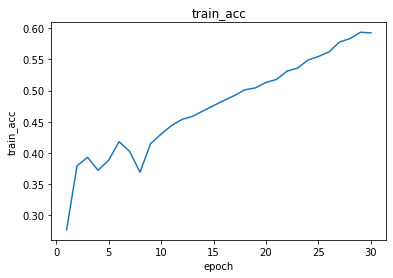

In [ ]:
model.plot('train_acc')
model.plot('train_loss')
model.plot('val_acc')
model.plot('val_loss')
model.plot('confusion_train')
model.plot('confusion_normalize_train')
model.plot('confusion_val')
model.plot('confusion_normalize_val')

FileNotFoundError: ignored

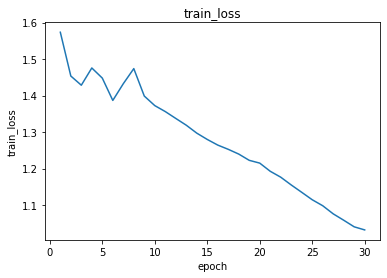

In [ ]:
model.plot('train_loss')

FileNotFoundError: ignored

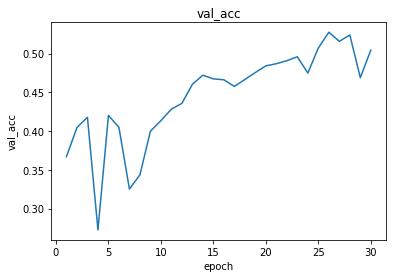

In [ ]:
model.plot('val_acc')

FileNotFoundError: ignored

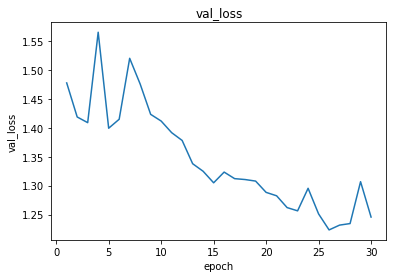

In [ ]:
model.plot('val_loss')

FileNotFoundError: ignored

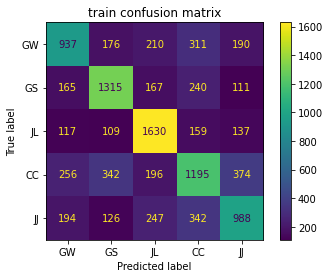

In [ ]:
model.plot('confusion_train')

FileNotFoundError: ignored

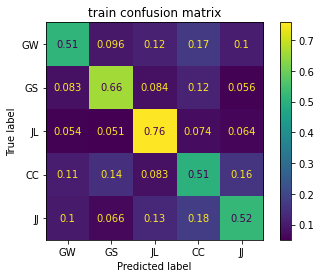

In [ ]:
model.plot('confusion_normalize_train')

FileNotFoundError: ignored

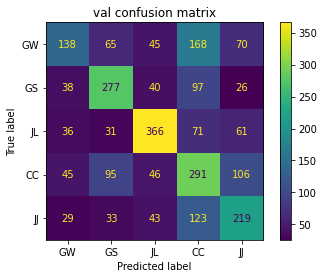

In [ ]:
model.plot('confusion_val')

FileNotFoundError: ignored

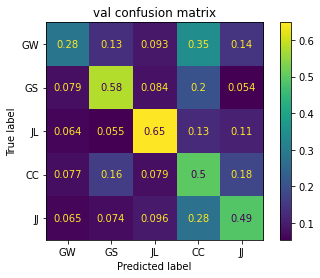

In [ ]:
model.plot('confusion_normalize_val')

In [ ]:
spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers = model.extractConvLayer()

In [ ]:
# model.plotFilter(where='first', data_type='spec', when='after_train')
# model.plotFilter(where='middle', data_type='spec', when='after_train')
# model.plotFilter(where='last', data_type='spec', when='after_train')
# model.plotFilter(where='first', data_type='mfcc', when='after_train')
# model.plotFilter(where='middle', data_type='mfcc', when='after_train')
# model.plotFilter(where='last', data_type='mfcc', when='after_train')
model.plotFilter(where='first', data_type='chroma', when='after_train')
model.plotFilter(where='middle', data_type='chroma', when='after_train')
model.plotFilter(where='last', data_type='chroma', when='after_train')

In [ ]:
model.plotFeatureMap(dataset[0][0][0].to(device), data_type='spec', when='after_train')
model.plotFeatureMap(dataset[0][0][1].to(device), data_type='mfcc', when='after_train')
model.plotFeatureMap(dataset[0][0][2].to(device), data_type='chroma', when='after_train')